# Segment Area

In [7]:
import time

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime
import torch
from segment_anything import sam_model_registry, SamPredictor

from app import load_image, get_embedding, ORT_SAM, SAM
from config import DATA_DIR

In [2]:
def show_mask(mask, ax):
    """Display a mask on a given matplotlib axis."""
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """Plot coordinates as points on a given matplotlib axis with different colors based on labels."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """Draw a box on a given matplotlib axis."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [3]:
# Set fixed seeds for reproducibility across PyTorch and NumPy operations.
torch.manual_seed(2023)
torch.cuda.empty_cache()
torch.cuda.manual_seed(2023)
np.random.seed(2023)

In [4]:
PREDICTOR = SamPredictor(sam_model=SAM)

Using device: cuda:0
Loading model...
Loaded model in 33.74s


In [12]:
IMAGE_NAME = "317947"
IMAGE_PATH = str(DATA_DIR.joinpath(f"{IMAGE_NAME}.jpg"))

IMAGE = load_image(IMAGE_PATH)
EMBEDDING = get_embedding(image=IMAGE, predictor=PREDICTOR, name=IMAGE_NAME)

Loaded image C:\Users\punit\projects\research\clotscape\data\317947.jpg with shape: (742, 932, 3)
Loading embedding from C:\Users\punit\projects\research\clotscape\data\embeddings\317947.npy


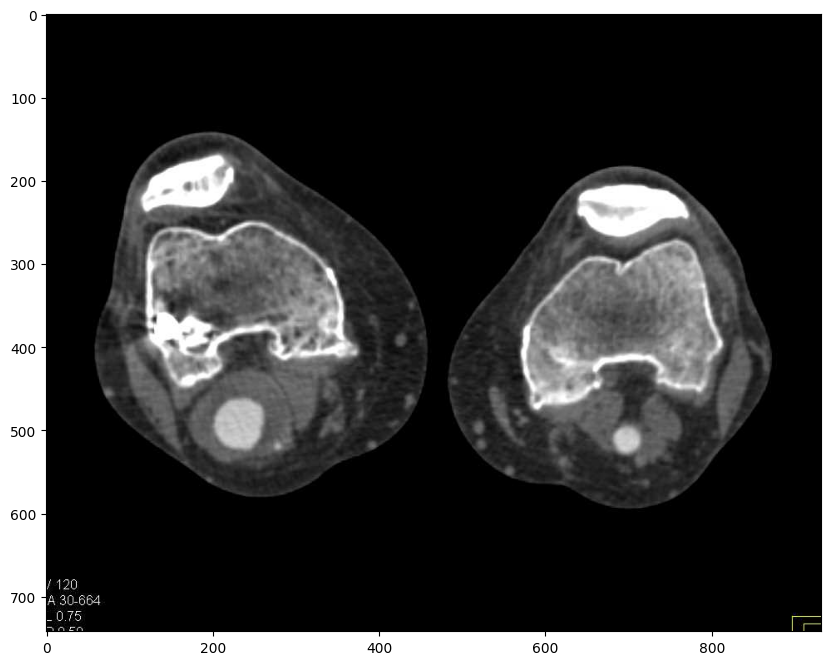

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(IMAGE)
plt.axis('on')
plt.show()

Set up ONNX inputs

In [38]:
input_box = np.array([500, 400, 800, 600])
input_point = np.array([[700, 500]])
input_label = np.array([0])

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = PREDICTOR.transform.apply_coords(onnx_coord, IMAGE.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

# Format the ONNX inputs
ort_inputs = {
    "image_embeddings": EMBEDDING,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(IMAGE.shape[:2], dtype=np.float32)
}

Predict masks

In [39]:
masks, _, _ = ORT_SAM.run(None, ort_inputs)
masks = masks > PREDICTOR.model.mask_threshold

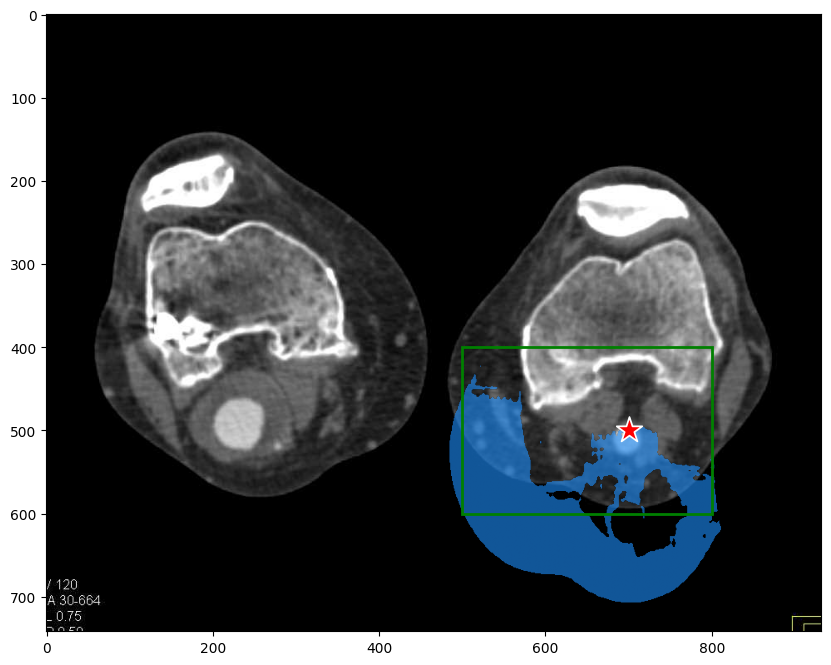

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(IMAGE)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [37]:
print(masks.shape)

(1, 1, 742, 932)
